In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_azure = pd.read_csv("/kaggle/input/azure-d/azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [3]:
df_azure['timestamp'] = pd.to_datetime(df_azure['timestamp'])
df_azure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8640 non-null   datetime64[ns]
 1   min cpu    8640 non-null   float64       
 2   max cpu    8640 non-null   float64       
 3   avg cpu    8640 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 270.1 KB


In [4]:
df_azure

,timestamp,min cpu,max cpu,avg cpu
0,2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
1,2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2,2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
3,2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
4,2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06
...,...,...,...,...
8635,2017-01-30 23:35:00,728008.315162,2.233166e+06,1.242129e+06
8636,2017-01-30 23:40:00,737452.951022,2.219408e+06,1.235937e+06
8637,2017-01-30 23:45:00,742153.686192,2.188120e+06,1.224276e+06
8638,2017-01-30 23:50:00,725404.574579,2.156483e+06,1.201533e+06


In [5]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df

,timestamp,avg cpu
0,2017-01-01 00:00:00,1.229569e+06
1,2017-01-01 00:05:00,1.211322e+06
2,2017-01-01 00:10:00,1.206635e+06
3,2017-01-01 00:15:00,1.190369e+06
4,2017-01-01 00:20:00,1.180992e+06
...,...,...
8635,2017-01-30 23:35:00,1.242129e+06
8636,2017-01-30 23:40:00,1.235937e+06
8637,2017-01-30 23:45:00,1.224276e+06
8638,2017-01-30 23:50:00,1.201533e+06


In [6]:
data = df.filter(['avg cpu'])
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

6912

In [7]:
train_data = df.iloc[0:int(training_data_len), :]
test_data = df.iloc[training_data_len - 60: , :]

In [8]:
def create_sequences_lstm_2(data, seq_length=12):
    xs = []
    ys = []
    indices = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0:1]  # Select only the feature columns
        y = data[i+seq_length, 0]  # Select the target value
        xs.append(x)
        ys.append(y)
        indices.append(data[i+seq_length, 1])  # Capture the timestamp for plotting
    return np.array(xs), np.array(ys), np.array(indices)

In [9]:
train_data = train_data[['avg cpu', 'timestamp']].to_numpy()
test_data = test_data[['avg cpu', 'timestamp']].to_numpy()

In [10]:
train_data.shape,test_data.shape

((6912, 2), (1788, 2))

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[:, 0] = scaler.fit_transform(train_data[:, 0].reshape(-1, 1)).flatten()
test_data[:, 0] = scaler.transform(test_data[:, 0].reshape(-1, 1)).flatten()    

In [13]:
X_train, y_train,indices_train  = create_sequences_lstm_2(train_data)
X_test, y_test,indices_test = create_sequences_lstm_2(test_data)

In [14]:
y_train = np.array([np.array([item]) for item in y_train])

In [15]:
y_test = np.array([np.array([item]) for item in y_test])

In [16]:
train_indices = pd.to_datetime(indices_train)
test_indices = pd.to_datetime(indices_test)

In [17]:
X_train[0],y_train[0]

(array([[0.29762310546498805],
        [0.2759800410560376],
        [0.27042115919930554],
        [0.2511280089037595],
        [0.24000641455688387],
        [0.2866158535762102],
        [0.25366547015095864],
        [0.22031577354098641],
        [0.21897754141797],
        [0.22023757647777553],
        [0.22274266020493916],
        [0.25139359795288807]], dtype=object),
 array([0.22844245]))

In [18]:
X_test[0],y_test[0]

(array([[0.41748757075237264],
        [0.3963954714763511],
        [0.4289235045402813],
        [0.47080224123054015],
        [0.4702853950827681],
        [0.4609194755444912],
        [0.42102914469466257],
        [0.4187044900629928],
        [0.4444025323177121],
        [0.4203968229595163],
        [0.39944886680117175],
        [0.4014469790535695]], dtype=object),
 array([0.38554465]))

In [19]:
indices_train[-1],indices_test[-1]

(Timestamp('2017-01-24 23:50:00'), Timestamp('2017-01-30 23:50:00'))

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

2024-04-15 09:52:23.606842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 09:52:23.606985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 09:52:23.770848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
from keras.layers import LSTM, Dense, Dropout, Bidirectional


# Initialize the model
model = Sequential()

# Add Bi-LSTM layers with more units and add dropout for regularization
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))  # Dropout for regularization

# Add more dense layers
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [22]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6899, 12, 1)
X_test shape: (1775, 12, 1)


In [23]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [24]:
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))
assert not np.any(np.isnan(y_train))
assert not np.any(np.isnan(y_test))

In [27]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100,validation_data=(X_test,y_test))
history

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - loss: 6.2654e-04 - val_loss: 4.8345e-04
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 5.7569e-04 - val_loss: 5.4492e-04
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 6.0433e-04 - val_loss: 4.9433e-04
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - loss: 5.7417e-04 - val_loss: 4.1132e-04
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 5.3445e-04 - val_loss: 4.9275e-04
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - loss: 5.7897e-04 - val_loss: 6.7361e-04
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - loss: 4.8963e-04 - val_loss: 4.8289e-04
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - loss: 5.6187e-04 - val_loss: 3.7220e-04
Epoch 9/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - loss: 6.1301e-04 - val_loss: 3.7703e-04
Epoch 10/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - loss: 5.4891e-04 - val_loss: 5.4273e-04
Epoch 11/100
432/432 ━━━━━━━━

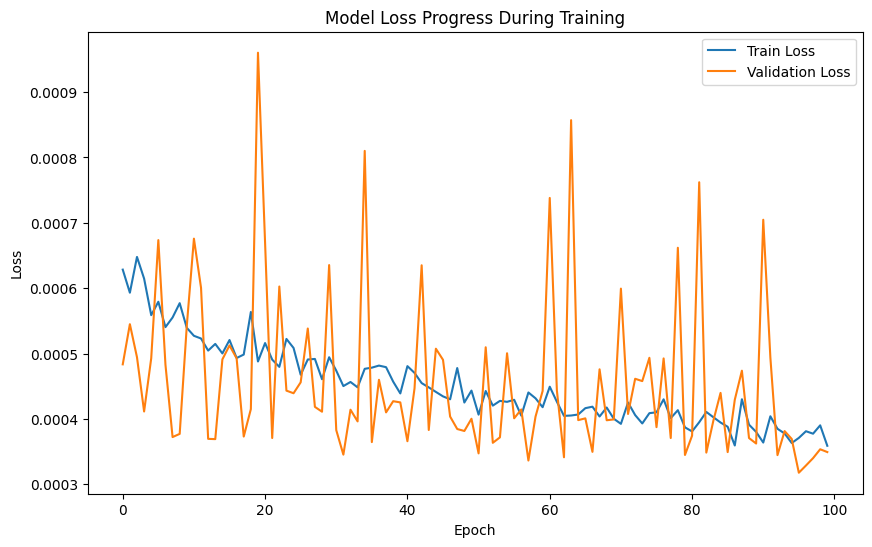

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predicting and inverse transform to original scale
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)
print('Train MAE:', train_mae)
print('Train MAPE:', train_mape)

print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)
print('Test MAE:', test_mae)
print('Test MAPE:', test_mape)


216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Train MSE: 197956060.0
Train RMSE: 14069.686
Train MAE: 10533.515
Train MAPE: 0.8731929585337639
Test MSE: 248305700.0
Test RMSE: 15757.719
Test MAE: 11481.76
Test MAPE: 0.8900156244635582


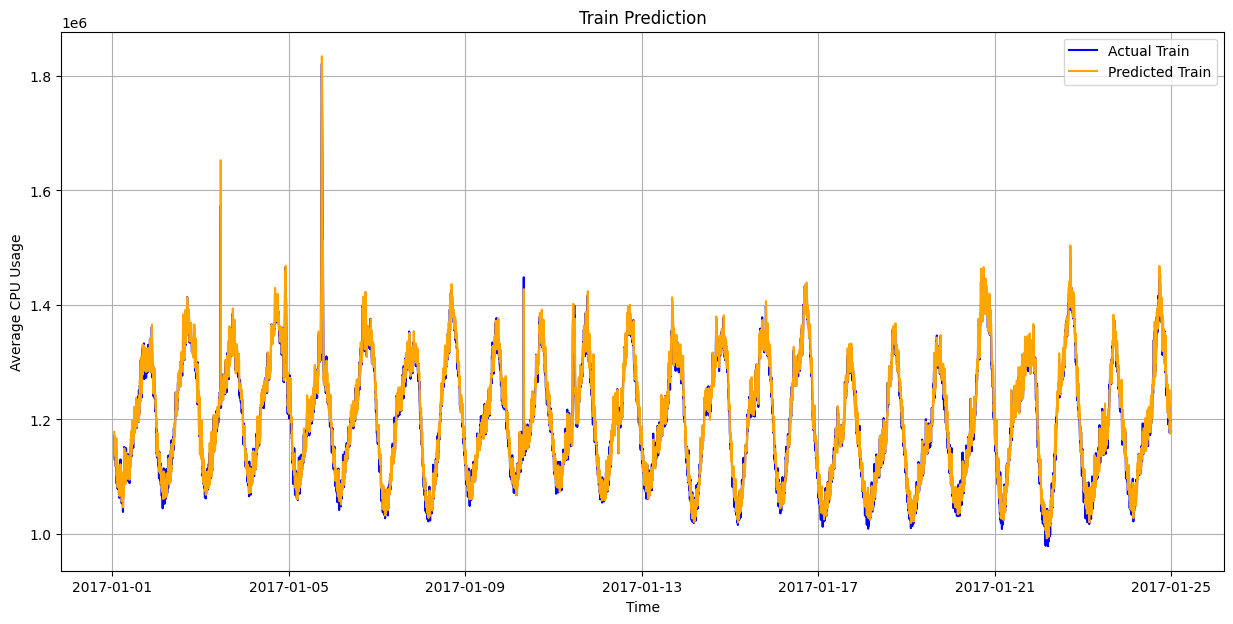

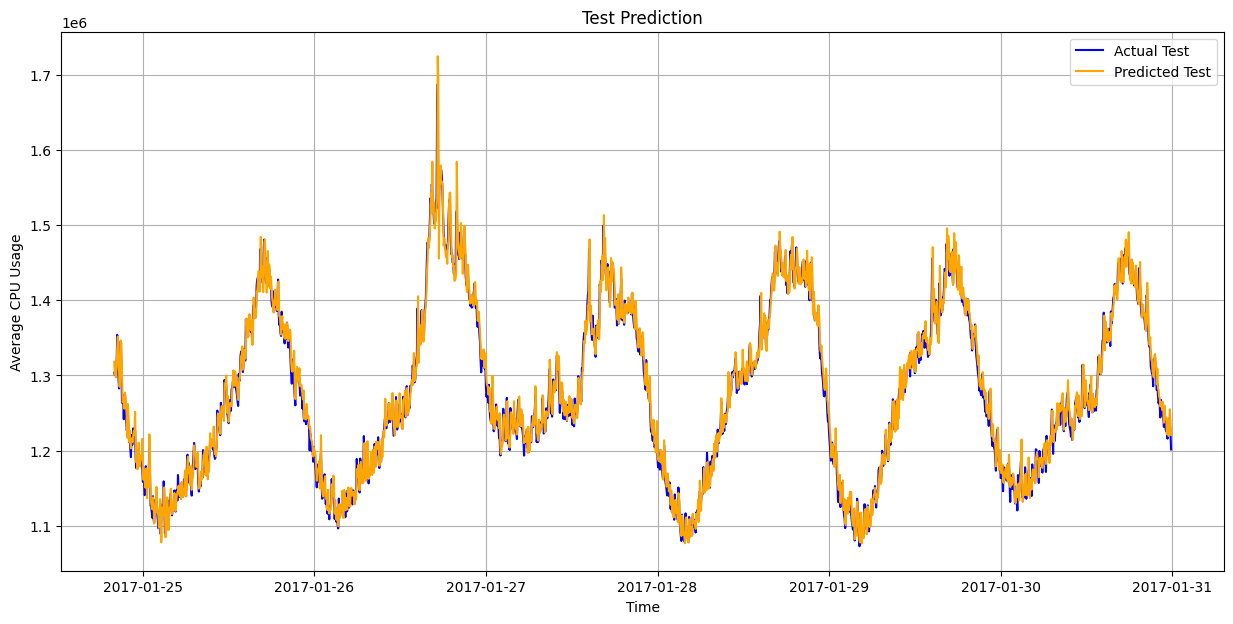

In [30]:
import matplotlib.pyplot as plt

# Ensure indices are in datetime format for plotting
train_indices = pd.to_datetime(train_indices)
test_indices = pd.to_datetime(test_indices)

# Plot training data
plt.figure(figsize=(15,7))
plt.plot(train_indices, y_train.flatten(), label='Actual Train', color='blue')
plt.plot(train_indices, y_train_pred.flatten(), label='Predicted Train', color='orange')
plt.title('Train Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.grid(True)
plt.show()

# Plot testing data
plt.figure(figsize=(15,7))
plt.plot(test_indices, y_test.flatten(), label='Actual Test', color='blue')
plt.plot(test_indices, y_test_pred.flatten(), label='Predicted Test', color='orange')
plt.title('Test Prediction')
plt.xlabel('Time')
plt.ylabel('Average CPU Usage')
plt.legend()
plt.grid(True)
plt.show()
